In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
df1 = pd.read_csv('/content/XAGUSD_5 Mins_Ask_2023.01.01_2023.06.30.csv')
df2 = pd.read_csv('/content/XAGUSD_5 Mins_Bid_2023.01.01_2023.06.30.csv')

In [3]:
# 1) Merge datasets
df = pd.concat([df1, df2]).drop_duplicates(subset=['Time (UTC)']).sort_values(by='Time (UTC)').reset_index(drop=True)

In [4]:
df.head()

,Time (UTC),Open,High,Low,Close,Volume
0,2023.01.02 23:00:00,24.102,24.125,24.083,24.125,0.3510
1,2023.01.02 23:05:00,24.094,24.188,24.094,24.141,1.1550
2,2023.01.02 23:10:00,24.143,24.148,24.022,24.027,0.8820
3,2023.01.02 23:15:00,24.026,24.028,23.986,24.028,0.8940
4,2023.01.02 23:20:00,24.026,24.073,24.023,24.073,0.9044


In [5]:
df.columns

Index(['Time (UTC)', 'Open', 'High', 'Low', 'Close', 'Volume '], dtype='object')

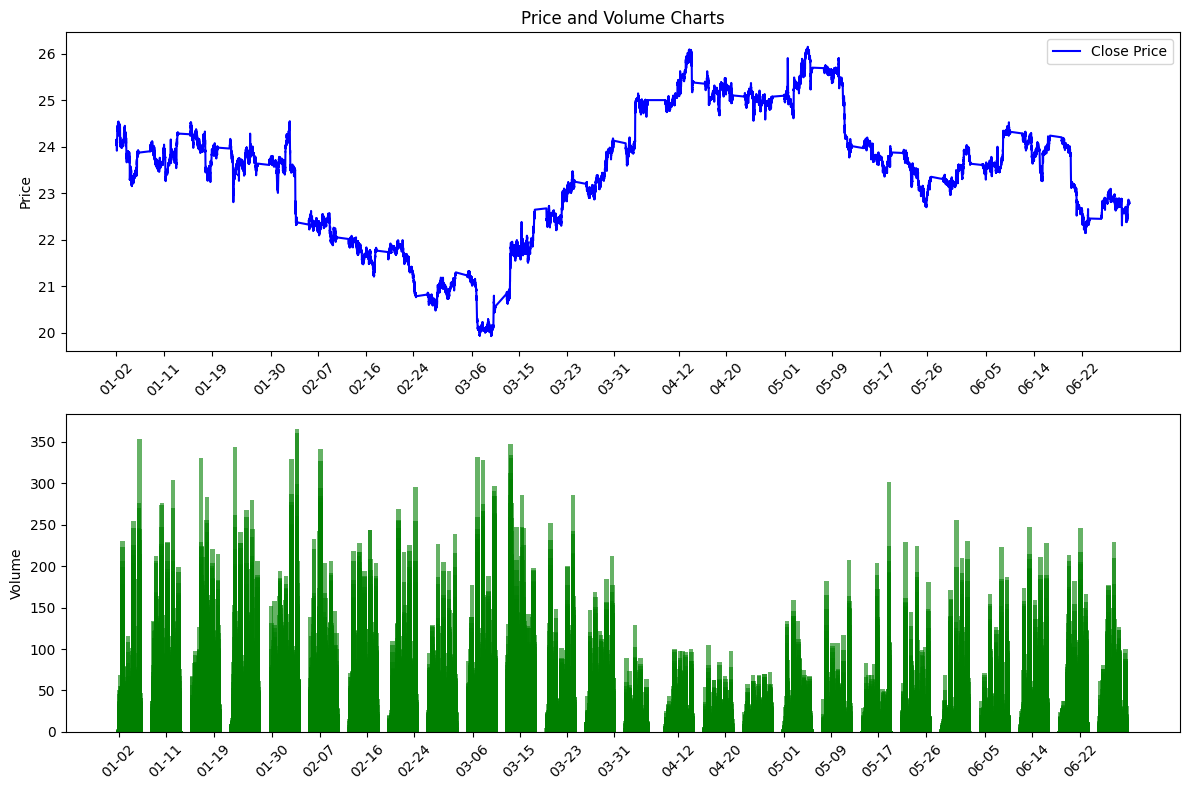

In [6]:
# 2) Plot price and volume charts with better x-axis labels
plt.figure(figsize=(12, 8))

# Convert Time to datetime and sample for better readability
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)'])
sampled_df = df.iloc[::len(df)//20]  # Sample approximately 20 points for x-axis

plt.subplot(2, 1, 1)
plt.plot(df['Time (UTC)'], df['Close'], label='Close Price', color='blue')
plt.title('Price and Volume Charts')
plt.ylabel('Price')
plt.xticks(sampled_df['Time (UTC)'], [date.strftime('%m-%d') for date in sampled_df['Time (UTC)']], rotation=45)
plt.legend()

plt.subplot(2, 1, 2)
plt.bar(df['Time (UTC)'], df['Volume '], color='green', alpha=0.6)
plt.ylabel('Volume')
plt.xticks(sampled_df['Time (UTC)'], [date.strftime('%m-%d') for date in sampled_df['Time (UTC)']], rotation=45)
plt.tight_layout()
plt.show()

In [7]:
# 3) Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume ']])

In [8]:
# 4) Shift min and max prices (already handled by MinMaxScaler)
print(f"Original price range: {df['Close'].min():.2f}-{df['Close'].max():.2f}")
print(f"Scaled price range: {scaled_data[:,3].min():.2f}-{scaled_data[:,3].max():.2f}")

Original price range: 19.92-26.15
Scaled price range: 0.00-1.00


In [9]:
# 5) Separate input and output matrices
X = []
y = []
look_back = 3  # Number of time steps to look back

for i in range(look_back, len(scaled_data)):
    X.append(scaled_data[i-look_back:i, :])  # All features for look_back period
    y.append(scaled_data[i, 3])  # Predicting Close price

X, y = np.array(X), np.array(y)

In [10]:
# 6) Create a 3D Tensor (already done in previous step)
print(f"3D Tensor shape: {X.shape}")  # (samples, timesteps, features)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(y_train).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(y_test).view(-1, 1)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)

3D Tensor shape: (35217, 3, 5)


In [11]:
# 7) Create LSTM model using PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)

        # Forward propagate LSTM
        out, _ = self.lstm1(x, (h0, c0))
        out = self.dropout1(out)
        out, _ = self.lstm2(out)
        out = self.dropout2(out)

        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

# Model parameters
input_size = X_train.shape[2]  # Number of features
hidden_size = 50
num_layers = 1
output_size = 1
dropout_rate = 0.2

# Initialize model
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout_rate)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
train_losses = []
val_losses = []
epochs = 50

for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    # Calculate average training loss for the epoch
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_train_tensor)
        val_loss = criterion(val_outputs, y_train_tensor)
        val_losses.append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss.item():.6f}')

Epoch [10/50], Train Loss: 0.002337, Val Loss: 0.051694
Epoch [20/50], Train Loss: 0.000897, Val Loss: 0.019699
Epoch [30/50], Train Loss: 0.000732, Val Loss: 0.016872
Epoch [40/50], Train Loss: 0.000689, Val Loss: 0.015257
Epoch [50/50], Train Loss: 0.000669, Val Loss: 0.013198


In [15]:
# 8) Calculate MSE and MAE on test dataset
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.numpy()

test_pred = np.zeros((len(y_pred), 5))
test_actual = np.zeros((len(y_test), 5))

# Place the predicted and actual values in the 'Close' position (index 3)
test_pred[:, 3] = y_pred.flatten()
test_actual[:, 3] = y_test.flatten()

# Inverse transform
test_predictions = scaler.inverse_transform(test_pred)[:, 3]
test_actual = scaler.inverse_transform(test_actual)[:, 3]

mse = mean_squared_error(test_actual, test_predictions)
mae = mean_absolute_error(test_actual, test_predictions)

print(f"\nTest MSE: {mse:.6f}")
print(f"Test MAE: {mae:.6f}")


Test MSE: 0.058144
Test MAE: 0.212149


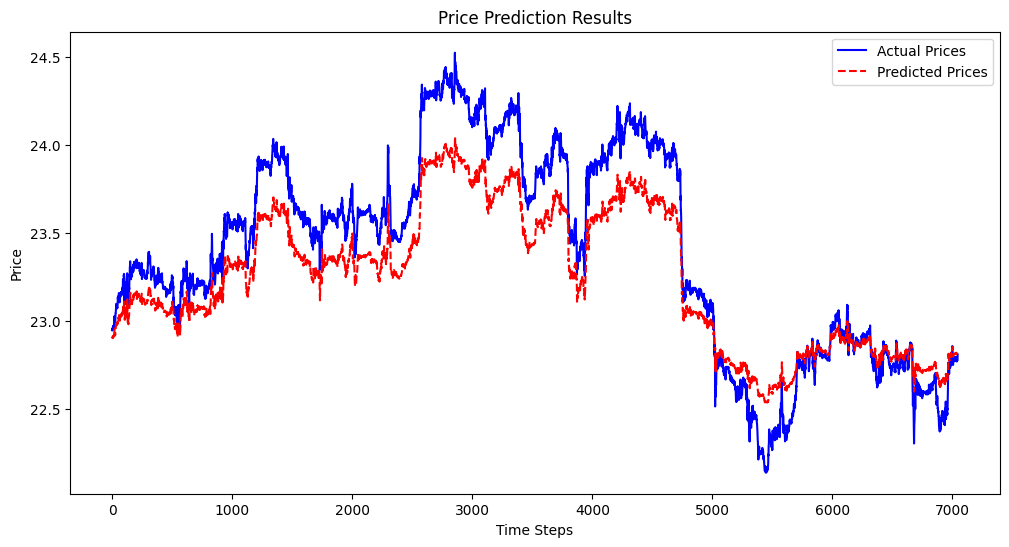

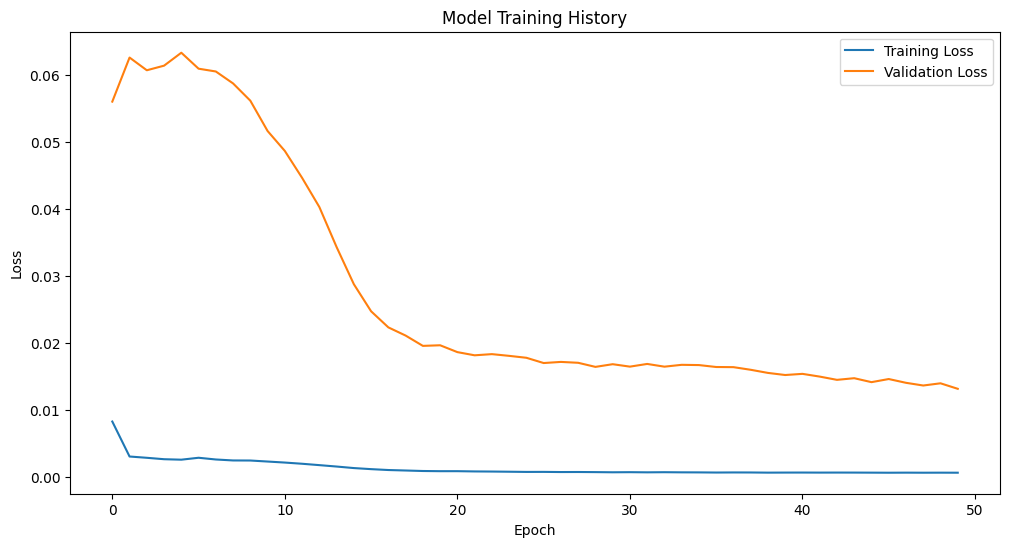

In [16]:
# 9) Plotting the results graphs
plt.figure(figsize=(12, 6))
plt.plot(test_actual, label='Actual Prices', color='blue')
plt.plot(test_predictions, label='Predicted Prices', color='red', linestyle='--')
plt.title('Price Prediction Results')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot training history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()